In [1]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [2]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [3]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [4]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [5]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [6]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
text_embs.shape

torch.Size([1000, 1024])

In [8]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [9]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [10]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

### Alternate Train(?) scheme: Only FT on Image and only FT on Text

In [12]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [13]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [14]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

# text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))
# text_only_balanced_clf_3 = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))


image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/07-Nov-2022-18-27-46/final_model.sav", 'rb'))
image_only_clf_4 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))
# image_only_clf_oversampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_undersampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_0-5/12-Nov-2022-12-17-52/final_model.sav", 'rb'))
image_only_clf_undersampled = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_auto/class_balanced/07-Nov-2022-20-18-24/final_model.sav", 'rb'))


In [23]:
def class_wise_accuracy(preds, labels):
    accs = np.zeros(1000)
    accs_count = np.zeros(1000)
    corr = preds == labels
    for i in range(len(labels)):
        if corr[i] == True:
            accs[labels[i]] +=1
        accs_count[labels[i]] +=1
    accs = np.divide(accs, accs_count)
    return accs

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

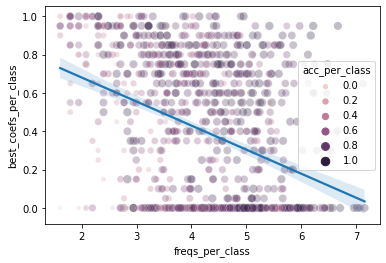

In [24]:
# Assess best coefficient per class

coefs = []
val_instance_preds = []
class_wise_accs = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_val)
    cwa = class_wise_accuracy(preds, labels_val.numpy())
    class_wise_accs.append(cwa)
    val_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [25]:
np.mean(np.max(np.array(class_wise_accs), axis=0))

0.72075

In [26]:
# Assess best coefficient per class

coefs = []
test_instance_preds = []
class_wise_accs_test = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_train)
    cwa = class_wise_accuracy(preds, labels_train.numpy())
    class_wise_accs_test.append(cwa)
    test_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs_test), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs_test), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

np.mean(np.max(np.array(class_wise_accs_test), axis=0))

# df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
#                columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

# sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
# sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

  0%|          | 0/21 [00:00<?, ?it/s]

0.8997714887729154

In [27]:
train_instance_preds = test_instance_preds

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

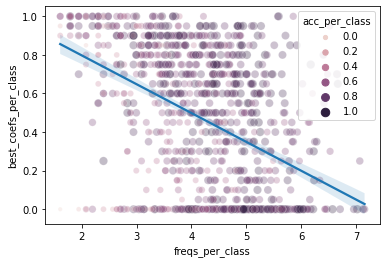

In [28]:
# Assess best coefficient per class

coefs = []
test_instance_preds = []
class_wise_accs_test = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    cwa = class_wise_accuracy(preds, labels.numpy())
    class_wise_accs_test.append(cwa)
    test_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs_test), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs_test), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [19]:
np.mean(np.max(np.array(class_wise_accs_test), axis=0))

0.6997000000000001

In [20]:
class_wise_accs_test = class_wise_accs

out = []
for i in range(1000):
    for j in indices_of_best_coefs:
        out.append(class_wise_accs_test[j][i])
        
np.mean(out)

0.6372135499999998

In [29]:
val_instance_preds = np.array(val_instance_preds)
np.savez('val_instance_preds.npz', arr1=val_instance_preds)
train_instance_preds = np.array(train_instance_preds)
np.savez('train_instance_preds.npz', arr1=train_instance_preds)
test_instance_preds = np.array(test_instance_preds)
np.savez('test_instance_preds.npz', arr1=test_instance_preds)

In [21]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.45
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Med:
i = 0.65
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Few:
i = 0.9
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

acc = 0
for i in tqdm(range(50000)):
    if freqs[labels[i].item()] >= 100:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif freqs[labels[i].item()] >= 20:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.65644


In [22]:
best_possible_acc/50000.0

NameError: name 'best_possible_acc' is not defined

In [100]:
all_accs_p(np.array(acc_preds))

0.740/0.791/0.731/0.623


[0.73978, 0.7909462915601023, 0.7311205073995771, 0.6227941176470588]

In [ ]:
graph = sns.pointplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)

graph = sns.scatterplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)
blah = df_corr_det
# graph = sns.kdeplot(data=blah, x = "num dsgrmnts", y = "correct_coefs", fill=True, common_norm=False, palette="crest", alpha=.5)

plt.xlim([-1, 10])
plt.ylim([-1, 1])

In [249]:
df_corr_det[df_corr_det["num dsgrmnts"] == 10]

,correct_coefs,freq,num dsgrmnts


In [274]:
disagreement_test = []
for preds in zip(*pred_list):
    disagreement_test.append(len(np.unique(preds)))
print(len(disagreement_test))

disagreement_val = []
for preds in zip(*pred_list_val):
    disagreement_val.append(len(np.unique(preds)))
print(len(disagreement_val))

50000
20000


### Train a Linear layer to predict mixing coefficients 

In [23]:
from sklearn.linear_model import LinearRegression

### (i) Just image and text scores

In [33]:
# ### TRAIN SET

# # image classification scores

# train_scores = image_only_clf_oversampled.predict_proba(image_embeddings_train)
print("Train Classification Scores: ", train_scores.shape)

# # text classification scores

# text_train_scores = text_only_balanced_clf.predict_proba(image_embeddings_train)
print("Train Text Classification Scores: ", text_train_scores.shape)

# # combine
# input_features = np.concatenate((train_scores, text_train_scores), axis=-1)
print("Train Combined input Features:", input_features.shape)


# # Get correct coefficients for correctly classified samples from val set

# indices = [] # indices corresponding to coefs
# corr_coefs = [] # coefs corresponding to input

# coefs = np.array([i/20.0 for i in range(0, 21)])
# remove_from_train = []
# for i, z in tqdm(enumerate(zip(*train_instance_preds))):
#     z = np.array(z)
#     inds = np.where(z == labels_train[i].item())[0]
#     if len(inds) > 0 :
#         correct_coefs = coefs[inds]
#         indices.append(i)
#         corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
#     else:
#         remove_from_train.append(i)
#         corr_coefs.append([-1, -1])
        
# indices = np.array(indices)
# corr_coefs = np.array(corr_coefs)

print("Size of viable data:", len(indices), len(corr_coefs))

X_train_filt = []
for x in tqdm(range(image_embeddings_train.shape[0])):
    if x not in remove_from_train:
        X_train_filt.append(x)
        

print("Viable train data:", image_embeddings_train.shape[0], len(X_train_filt))

ie_train = image_embeddings_train[X_train_filt]
vlabels_train = labels_train[X_train_filt]
corr_coefs_train = corr_coefs[X_train_filt]
input_features_train = input_features[X_train_filt]

print("Train Dims")
print(ie_train.shape)
print(vlabels_train.shape)
print(corr_coefs_train.shape)
print(input_features_train.shape)

Train Classification Scores:  (115846, 1000)
Train Text Classification Scores:  (115846, 1000)
Train Combined input Features: (115846, 2000)
Size of viable data: 99314 115846


  0%|          | 0/115846 [00:00<?, ?it/s]

Viable train data: 115846 99314
Train Dims
torch.Size([99314, 1024])
torch.Size([99314])
(99314, 2)
(99314, 2000)


In [86]:
blah = np.vstack((input_features_train, val_inputs))
blah_coefs = np.vstack((corr_coefs_train, corr_coefs_val))
print(blah.shape, blah_coefs.shape)

(114323, 2000) (114323, 2)


In [39]:
### VAL SET

# Get correct coefficients for correctly classified samples from val set

val_indices = [] # indices corresponding to coefs
corr_coefs_val = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        val_indices.append(i)
        corr_coefs_val.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
val_indices = np.array(val_indices)
val_targets = np.array(corr_coefs_val)

# image classification scores

val_scores = image_only_clf_oversampled.predict_proba(image_embeddings_val)
print("Val Image Classification Scores: ", val_scores.shape)

# text classification scores

text_val_scores = text_only_balanced_clf.predict_proba(image_embeddings_val)
print("Val Text Classification Scores: ", text_val_scores.shape)

# combine
input_features_val = np.concatenate((val_scores, text_val_scores), axis=-1)
print("Val Combined input Features:", input_features_val.shape)

val_inputs = input_features_val[val_indices, :]
vlabels_val = labels[val_indices]
corr_coefs_val = np.array(corr_coefs_val)

print(val_inputs.shape)
print(corr_coefs_val.shape)
print(input_features_val.shape)

0it [00:00, ?it/s]

Val Image Classification Scores:  (20000, 1000)
Val Text Classification Scores:  (20000, 1000)
Val Combined input Features: (20000, 2000)
(15009, 2000)
(15009, 2)
(20000, 2000)


In [40]:
## TEST SET

# Get correct coefficients for correctly classified samples from test set

test_indices = [] # indices corresponding to coefs
corr_coefs_test = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        corr_coefs_test.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
test_indices = np.array(test_indices)
test_targets = np.array(corr_coefs_test)

# Image scores
test_scores = image_only_clf_oversampled.predict_proba(image_embeddings)

# Text scores
text_scores_test = text_only_balanced_clf.predict_proba(image_embeddings)

# Combine
input_features_test = np.concatenate((test_scores, text_scores_test), axis=-1)

# Align
test_inputs = input_features_test[test_indices, :]
corr_coefs_test = np.array(corr_coefs_test)

print(test_inputs.shape)
print(corr_coefs_test.shape)
print(input_features_test.shape)

0it [00:00, ?it/s]

(36989, 2000)
(36989, 2)
(50000, 2000)


In [42]:
def evaluate_acc(coef_preds, labels, ie, v = False, test=False):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
    acc = 0
    preds = []
    for j in tqdm(range(coef_preds.shape[0])):
        i = coef_preds[j][0].item() 
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(ie[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels[j].item():
            acc+=1
        if j>0 and j%1000== 0 and v:
            blah = acc*100/j
            print(f"{blah:.3f}, {j}")
    if test:
        all_accs_p(np.array(preds))
    return acc*100/j



In [63]:
import torch
import torch.nn as nn
import copy 

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
        self.bn = nn.LayerNorm(100)
        self.do = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.linear2(x)
        out = self.m(x)
        return out

def loss_fn(output, target):
    mse = nn.MSELoss()
    loss1 = mse(output,target)
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0

for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()

    if epoch%10 == 0 and epoch > 1:
        print(f'epoch {epoch}, loss {loss.item():.5f}')
        
#     if epoch%50 == 0 and epoch > 1:
#         model.eval()
#         val_coef_preds = model(torch.from_numpy(input_features_val).float())
#         val_acc = evaluate_acc(val_coef_preds, labels_val, image_embeddings_val)
#         if val_acc > best_acc:
#             print("Updating best model")
#             best_acc = val_acc
#             best_model = copy.deepcopy(model)
#         print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [88]:
import torch
import torch.nn as nn
import copy 

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
#         self.bn = nn.LayerNorm(100)
#         self.do = nn.Dropout(p=0.2)
#         self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.bn(x)
#         x = self.linear2(x)
        out = self.m(x)
        return out

mse = nn.MSELoss()
def loss_fn(output, target):
    loss1 = mse(output,target)
    return loss1

epochs = 5000
model = LinearRegressionModel(2000, 2)
learning_rate = 0.005
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
best_model = model
best_acc = 0
optimizer = torch.optim.LBFGS(model.parameters(),
                    history_size=10, 
                    max_iter=4, lr = 1)

inputs = torch.from_numpy(blah).float()
targets = torch.from_numpy(blah_coefs).float()


for epoch in range(epochs):
    model.train()
    
    # Forward to get output
    outputs = model(inputs)
    
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward(retain_graph=True)
        return loss
    
    # Updating parameters
    optimizer.step(closure)
    sched.step()

    # Calculate Loss
    loss = loss_fn(outputs, targets)

    if epoch%10 == 0 and epoch > 1:
        print(f'epoch {epoch}, loss {loss.item():.5f}')
        
#     if epoch%50 == 0 and epoch > 1:
#         model.eval()
#         val_coef_preds = model(torch.from_numpy(input_features_val).float())
#         val_acc = evaluate_acc(val_coef_preds, labels_val, image_embeddings_val)
#         if val_acc > best_acc:
#             print("Updating best model")
#             best_acc = val_acc
#             best_model = copy.deepcopy(model)
#         print(f'epoch {epoch}, loss {loss.item():.5f}, v_acc {val_acc:.3f}')

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 10, loss 0.01190
epoch 20, loss 0.01158
epoch 30, loss 0.01144
epoch 40, loss 0.01134
epoch 50, loss 0.01129
epoch 60, loss 0.01126
epoch 70, loss 0.01124
epoch 80, loss 0.01123
epoch 90, loss 0.01123
epoch 100, loss 0.01122
epoch 110, loss 0.01122
epoch 120, loss 0.01121
epoch 130, loss 0.01121
epoch 140, loss 0.01121
epoch 150, loss 0.01121
epoch 160, loss 0.01120
epoch 170, loss 0.01120
epoch 180, loss 0.01120
epoch 190, loss 0.01119
epoch 200, loss 0.01118
epoch 210, loss 0.01117
epoch 220, loss 0.01116
epoch 230, loss 0.01116
epoch 240, loss 0.01116
epoch 250, loss 0.01114
epoch 260, loss 0.01113
epoch 270, loss 0.01112
epoch 280, loss 0.01111
epoch 290, loss 0.01111
epoch 300, loss 0.01110
epoch 310, loss 0.01110
epoch 320, loss 0.01109
epoch 330, loss 0.01109
epoch 340, loss 0.01111
epoch 350, loss 0.01108
epoch 360, loss 0.01108
epoch 370, loss 0.01107
epoch 380, loss 0.01107


KeyboardInterrupt: 

In [89]:
best_model.eval()
with torch.no_grad():
    train_coef_preds = best_model(torch.from_numpy(input_features_train).float())
    print(train_coef_preds.shape)        
    val_coef_preds = best_model(torch.from_numpy(input_features_val).float())
    print(val_coef_preds.shape)  
    test_coef_preds = best_model(torch.from_numpy(input_features_test).float())
    print(test_coef_preds.shape)        

torch.Size([99314, 2])
torch.Size([20000, 2])
torch.Size([50000, 2])


In [90]:
# print(evaluate_acc(train_coef_preds, vlabels_train, ie_train))
# print(evaluate_acc(val_coef_preds, labels_val, image_embeddings_val))
print(evaluate_acc(test_coef_preds, labels.numpy(), image_embeddings, test = True))

  0%|          | 0/50000 [00:00<?, ?it/s]

0.642/0.728/0.630/0.435
64.16928338566771
